# A first attempt at training on the maria data

Here we are trying to train a transformer on the TODs directly, mapping to the CMB tod component.

## Step 1: Generate data with maria

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

import maria

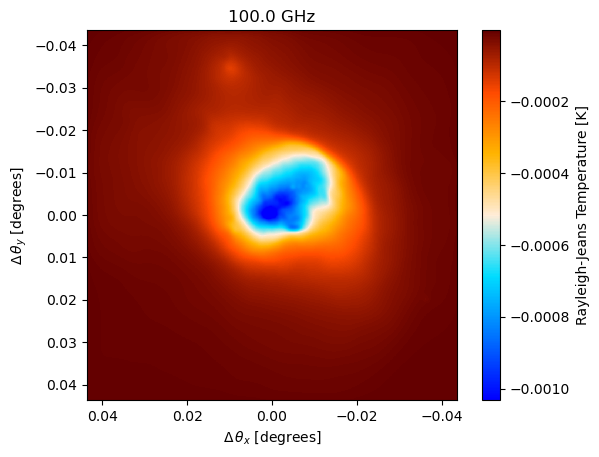

In [2]:
map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

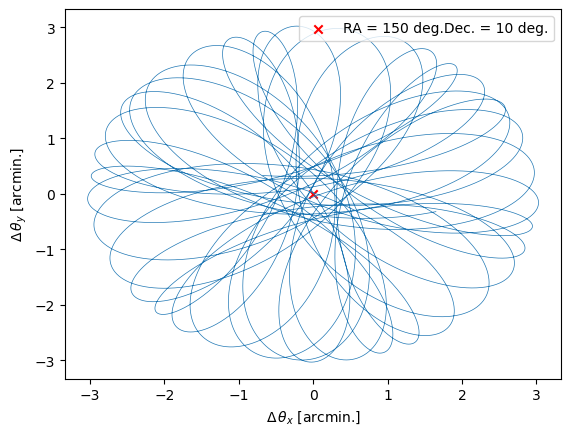

In [3]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

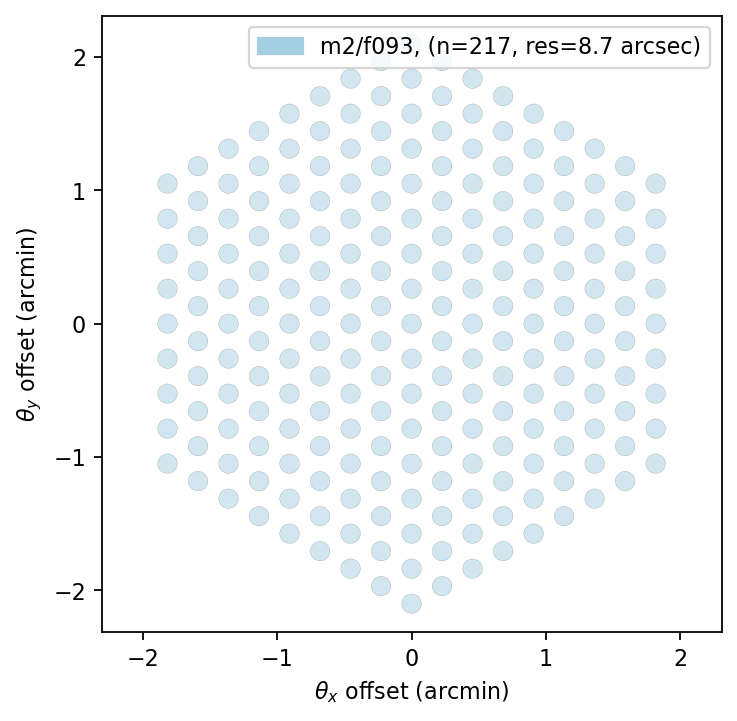

In [4]:
instrument = maria.get_instrument('MUSTANG-2')
instrument.plot()

In [5]:
sim = maria.Simulation(instrument, 
                       plan=plan,
                       site="llano_de_chajnantor", 
                       map=input_map,
                       atmosphere="2d",
                       cmb="generate",
                      )

tod = sim.run()

2024-07-16 13:39:03.240 INFO: Constructed instrument.
2024-07-16 13:39:03.241 INFO: Constructed plan.
2024-07-16 13:39:03.241 INFO: Constructed site.
2024-07-16 13:39:03.751 INFO: Constructed boresight.
2024-07-16 13:39:03.983 INFO: Constructed offsets.


Initialized base in 743 ms.


Generating CMB:   0%|          | 0/1 [00:00<?, ?it/s]2024-07-16 13:39:05.740 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
2024-07-16 13:39:05.741 INFO: -> fwhm is 0.000000 arcmin
Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]
Generating atmosphere: 4it [00:00,  4.62it/s]
Sampling map (m2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Data and components are stored in tod.components and tod.data:

In [6]:
tod.components

{'atmosphere': dask.array<array, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>,
 'cmb': dask.array<array, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>,
 'map': dask.array<array, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>,
 'noise': dask.array<setitem, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>}

In [7]:
tod.data

dask.array<add, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>

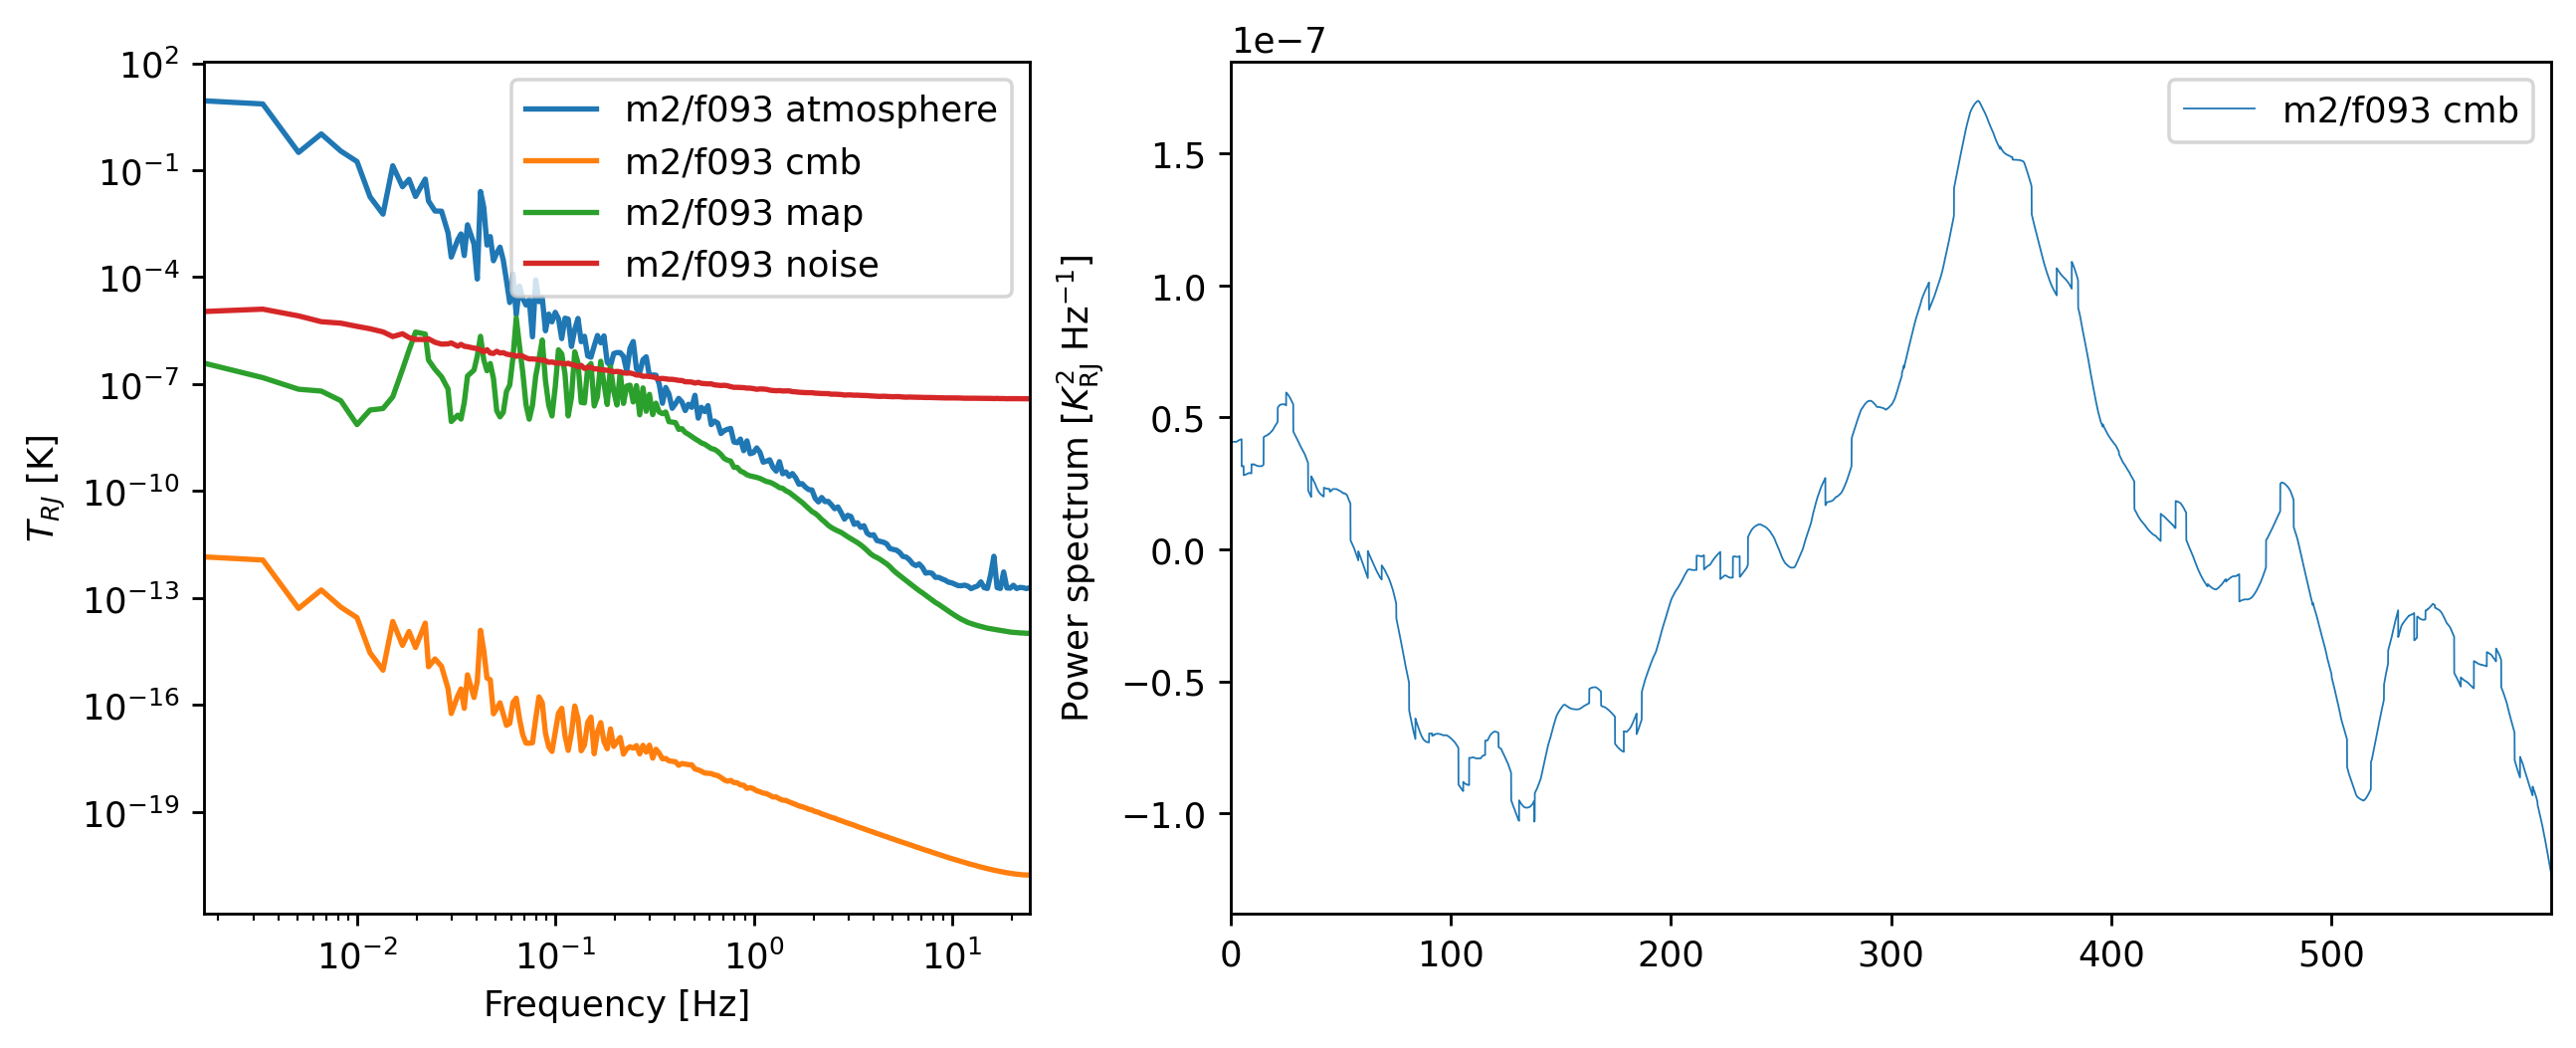

In [8]:
tod.plot(calibrate=True, detrend=True)

## Baseline reco to compare to:

baseline denoised TOD does not exist anymore?

calling _run for band m2/f093


Running mapper (m2/f093):   0%|          | 0/1 [00:00<?, ?it/s]

self.tods: [TOD(shape=(217, 30000), fields=['atmosphere', 'cmb', 'map', 'noise'])]
TOD(shape=(217, 30000), fields=['atmosphere', 'cmb', 'map', 'noise'])
Band_tod: TOD(shape=(217, 30000), fields=['atmosphere', 'cmb', 'map', 'noise'])


Running mapper (m2/f093): 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


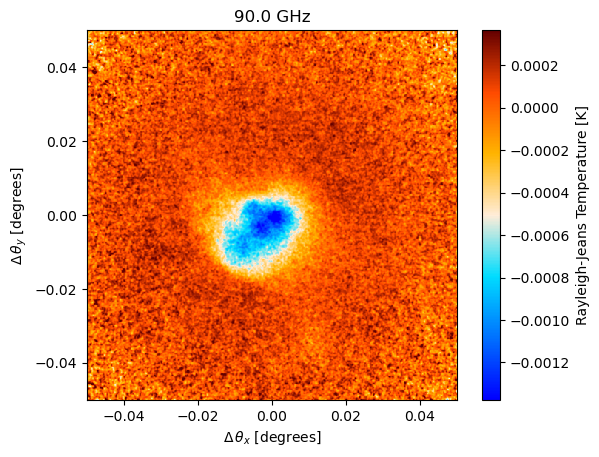

In [9]:
from maria.map.mappers import BinMapper

mapper = BinMapper(center=(150, 10), 
                   frame="ra_dec", 
                   width=0.1, 
                   height=0.1,
                   resolution=2e-4,
                   tod_postprocessing={
                        "remove_modes": {"n": 1},
                        # "highpass": {"f": 0.01},
                        "despline": {"spacing": 10},
                    },
                    map_postprocessing={
                        "gaussian_filter": {"sigma": 1},
                        "median_filter": {"size": 1},
                    },
                  )

mapper.add_tods(tod)
output_map = mapper.run()

output_map.plot()

In [10]:
# TODO: Make plot of baseline PS. Broken atm, since `mapper.DATA` does not exist anymore.
# See working: https://github.com/thomaswmorris/maria/blob/f0ea09ee2e97d70bfb07bbdfb520aa4ebd79ac55/docs/source/tutorials/MUSTANG-2_cluster.ipynb
# vs new: https://thomaswmorris.com/maria/tutorials/MUSTANG-2_cluster.html

# dt = (tod.time[1] - tod.time[0]).compute()
# data = mapper.DATA

# # visualize powerspectrum
# # -----------------------
# f, ps = sp.signal.periodogram(data, fs=1/dt, window="tukey")

# fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=256, tight_layout=True, gridspec_kw={'width_ratios': [1, 1.6]})
# fig.suptitle('Raw time streams')

# for i in range(-20,20,2): axes[0].plot(np.logspace(-7, 3,100), np.logspace(-7, 3,100) ** (-3)/1e11/(10**i), c = 'gray', alpha = 0.2, ls = '--', lw = 1)

# axes[0].plot(f[1:], ps.mean(axis=0)[1:], label="Combined", alpha = 0.7, c = 'C0', lw = 1.5, ls = '-')

# axes[0].set_xlabel(r"$\mathcal{f}$ [Hz]"), 
# axes[0].set_ylabel(r"$\mathcal{P}_{\rm Hz}[K_{\rm RJ}^2~{\rm Hz}^{-1}]$")
# axes[0].loglog()
# axes[0].legend(loc = 1, frameon=False)
# axes[0].axis(xmin=1e-2, xmax = 2e2, ymin = 1e-10, ymax = 1e2)

# axes[1].set_xlabel('Time [minutes]'), axes[1].set_ylabel("\n"+r'$I_\nu$ [$K_{\rm RJ}$]')
# axes[1].plot((tod.time - tod.time[0])/60, data[0], label = 'Real', alpha = 1., c = 'C0', lw = 1, ls = '-')
# plt.show()

## Step 2: Set up transformer

Question: How do we tokenise? Since we do already have numbers, maybe we don't need to? -> Yes!

In [11]:
target = 'atmosphere'
# target = 'cmb'

tod_train = sim.run()
tod_val = sim.run()
tod_test = sim.run()

Generating noise:   0%|          | 0/1 [00:00<?, ?it/s]

Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
Generating atmosphere: 4it [00:00,  4.57it/s]
Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]
Generating atmosphere: 4it [00:00,  4.72it/s]
Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
Generating atmosphere: 4it [00:00,  4.71it/s]
Sampling map (m2/f093): 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


In [12]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cuda')
torch.cuda.set_device(2) # which GPU to use
torch.set_num_threads(4) # how many threads to fill workers with
print("Using device:", DEVICE)

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
# MAXLEN = 30_000 # out of memory!
MAXLEN = 500
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                #  maxlen: int = 128):
                 maxlen: int = MAXLEN):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                #  src_vocab_size: int,
                #  tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.src_inlin = nn.Linear(217, emb_size)
        self.tgt_inlin = nn.Linear(217, emb_size)
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        # self.generator = nn.Linear(emb_size, tgt_vocab_size)
        # self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        # self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        self.tgt_outlin = nn.Linear(emb_size, 217)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                # src_padding_mask: Tensor,
                # tgt_padding_mask: Tensor,
                # memory_key_padding_mask: Tensor
                ):
        src_emb = self.positional_encoding(self.src_inlin(src))
        tgt_emb = self.positional_encoding(self.tgt_inlin(trg))
        
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask,
                                # src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
                                src_is_causal = False, tgt_is_causal = True)
        # return self.generator(outs)
        
        return self.tgt_outlin(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            # self.src_inlin(src)), src_mask, src_is_causal = False)
                            self.src_inlin(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        # print("MARKER1:", self.tgt_inlin(tgt).shape)
        # print("SUPERMARKER", self.tgt_inlin(tgt).unsqueeze(1).shape)
        # print("MARKER2:", self.positional_encoding(self.tgt_inlin(tgt).unsqueeze(1)).shape)
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_inlin(tgt).unsqueeze(1)), memory, tgt_mask, tgt_is_causal = True)

Using device: cuda


In [13]:
?Transformer

Init signature:
Transformer(
    d_model: int = 512,
    nhead: int = 8,
    num_encoder_layers: int = 6,
    num_decoder_layers: int = 6,
    dim_feedforward: int = 2048,
    dropout: float = 0.1,
    activation: Union[str, Callable[[torch.Tensor], torch.Tensor]] = <function relu at 0x7f94ae343560>,
    custom_encoder: Optional[Any] = None,
    custom_decoder: Optional[Any] = None,
    layer_norm_eps: float = 1e-05,
    batch_first: bool = False,
    norm_first: bool = False,
    bias: bool = True,
    device=None,
    dtype=None,
) -> None
Docstring:     
A transformer model.

User is able to modify the attributes as needed. The architecture
is based on the paper "Attention Is All You Need". Ashish Vaswani, Noam Shazeer,
Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Lukasz Kaiser, and
Illia Polosukhin. 2017. Attention is all you need. In Advances in Neural Information
Processing Systems, pages 6000-6010.

Args:
    d_model: the number of expected features in the encoder/d

In [14]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    # src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    # tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    # return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask
    return src_mask, tgt_mask

In [15]:
torch.manual_seed(0)

EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
# BATCH_SIZE = 200
BATCH_SIZE = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/scratch/users/jwuerzin/miniconda3/envs/maria/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [16]:
print("tod shape:", tod_train.data.compute().shape)
maxlen = 100

testtod = tod_train.data.compute()[:,:maxlen]
print("testtod shape:", testtod.shape)
print(testtod)

tod shape: (217, 30000)
testtod shape: (217, 100)
[[12.156046 12.156141 12.155753 ... 12.154099 12.154088 12.154142]
 [12.156515 12.156596 12.156114 ... 12.154854 12.154511 12.154438]
 [12.156126 12.15616  12.156424 ... 12.154103 12.153793 12.154359]
 ...
 [12.160055 12.160046 12.159482 ... 12.1579   12.157732 12.157901]
 [12.154288 12.154611 12.154222 ... 12.152927 12.152715 12.152598]
 [12.158377 12.158374 12.158408 ... 12.156178 12.156337 12.156324]]


In [17]:
seq_len = 3
batch_size = 5

i_start = torch.randint(0, maxlen-seq_len, size=(batch_size,))

print(i_start)

range_tensor = torch.arange(seq_len).unsqueeze(1)  # Shape: (seq_len, 1)
# range_tensor = torch.arange(seq_len)
print(range_tensor)

indices = (i_start + range_tensor).T.reshape(-1)
# indices = (i_start + range_tensor)
print("indices:", indices)

tensor([23, 25, 32, 81, 73])
tensor([[0],
        [1],
        [2]])
indices: tensor([23, 24, 25, 25, 26, 27, 32, 33, 34, 81, 82, 83, 73, 74, 75])


In [18]:
def give_batch(xdata: torch.Tensor, cmbdata: torch.Tensor, batch_size: int = 512, seq_len: int = 128):
    '''Makes batch_size batches with size seq_len from xdata and cmbdata.
    Returns in shape (seq_len, batch_size, 217).
    '''
    
    # pick random start positions
    i_start = torch.randint(0, 30_000-seq_len, size=(batch_size,))
    
    # create tensor with offsets from start positions
    range_tensor = torch.arange(seq_len).unsqueeze(1)  # Shape: (seq_len, 1)

    # Broadcast and add to i_start to get indices for all sequences
    indices = (i_start + range_tensor).T.reshape(-1)  # Shape: (seq_len * batch_size,)

    # Gather the sequences
    xdata_i = xdata[indices].reshape(seq_len, batch_size, 217)  # Shape: (seq_len, batch_size, feature_dim)
    cmbdata_i = cmbdata[indices].reshape(seq_len, batch_size, 217)
    
    return xdata_i, cmbdata_i

testtod_data = tod.data.compute()[:,:100]
testtod_cmb = tod.components[target].compute()[:,:100]
print("testtod_data shape:", testtod_data.shape)
print(testtod_data)

# in full:
give_batch(torch.Tensor(tod.data.compute().T), torch.Tensor(tod.components[target].compute().T))[0].shape

testtod_data shape: (217, 100)
[[12.166028  12.1664715 12.166123  ... 12.166203  12.166116  12.166075 ]
 [12.166217  12.16589   12.166337  ... 12.165827  12.166009  12.165767 ]
 [12.165946  12.165555  12.165477  ... 12.165349  12.165216  12.165197 ]
 ...
 [12.170156  12.16979   12.169579  ... 12.169059  12.169132  12.169159 ]
 [12.163892  12.163916  12.163985  ... 12.164246  12.163686  12.163761 ]
 [12.168358  12.16834   12.168016  ... 12.167776  12.168207  12.167662 ]]


torch.Size([128, 512, 217])

In [19]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer, xdata, cmbdata):
    model.train()
    losses = 0
    # train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    # for src, tgt in train_dataloader:
    
    for i in range(30_000//BATCH_SIZE):
    # for i in range(10):
        # print("HERE", i, 30_000//BATCH_SIZE)
        src, tgt = give_batch(xdata=xdata, cmbdata=cmbdata, batch_size=BATCH_SIZE, seq_len=128) # TODO: Too slow! Needs to be vectorised!!
        
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        # src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        src_mask, tgt_mask = create_mask(src, tgt_input)

        # logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        logits = model(src, tgt_input, src_mask, tgt_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        # loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1)) #TODO: sizes mismatched here!
        loss = loss_fn(logits.reshape(-1), tgt_out.reshape(-1)) 
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / xdata.shape[0]

In [20]:
def evaluate(model, xdata, cmbdata):
    model.eval()
    losses = 0

    for i in range(30_000//BATCH_SIZE):
    # for i in range(10):
        src, tgt = give_batch(xdata=xdata, cmbdata=cmbdata, batch_size=BATCH_SIZE, seq_len=128) # TODO: Too slow! Needs to be vectorised!!
        
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        # src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        src_mask, tgt_mask = create_mask(src, tgt_input)

        # logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        logits = model(src, tgt_input, src_mask, tgt_mask)

        tgt_out = tgt[1:, :]
        # loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss = loss_fn(logits.reshape(-1), tgt_out.reshape(-1)) 
        losses += loss.item()

    return losses / xdata.shape[0]

In [21]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
NUM_EPOCHS = 20
# NUM_EPOCHS = 2

train_losses = []
val_losses = []

xdata_train = torch.Tensor(tod_train.data.compute().T)
cmbdata_train = torch.Tensor(tod_train.components[target].compute().T)
xdata_val = torch.Tensor(tod_val.data.compute().T)
cmbdata_val = torch.Tensor(tod_val.components[target].compute().T)

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, xdata_train, cmbdata_train)
    end_time = timer()
    val_loss = evaluate(transformer, xdata_val, cmbdata_val)
    
    train_losses += [train_loss,]
    val_losses += [val_loss,]
    print((f"Epoch: {epoch}, Train loss: {train_loss}, Val loss: {val_loss}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    # print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 0.17927601877848306, Val loss: 0.1250304423014323, Epoch time = 12.301s
Epoch: 2, Train loss: 0.09202809569040935, Val loss: 0.05550684814453125, Epoch time = 12.124s
Epoch: 3, Train loss: 0.03637128553390503, Val loss: 0.017148196283976236, Epoch time = 12.123s
Epoch: 4, Train loss: 0.009611725699901581, Val loss: 0.0027136366645495098, Epoch time = 12.122s
Epoch: 5, Train loss: 0.0012730607775350412, Val loss: 9.310125460227331e-05, Epoch time = 12.121s
Epoch: 6, Train loss: 8.779995180666447e-05, Val loss: 3.572579479465882e-05, Epoch time = 12.154s
Epoch: 7, Train loss: 4.8470226240654786e-05, Val loss: 3.492644838988781e-05, Epoch time = 12.147s
Epoch: 8, Train loss: 4.701888288060824e-05, Val loss: 3.427859911074241e-05, Epoch time = 12.147s
Epoch: 9, Train loss: 4.546010550111532e-05, Val loss: 3.548218763122956e-05, Epoch time = 12.131s
Epoch: 10, Train loss: 4.372812279810508e-05, Val loss: 3.414381456871827e-05, Epoch time = 12.148s
Epoch: 11, Train loss

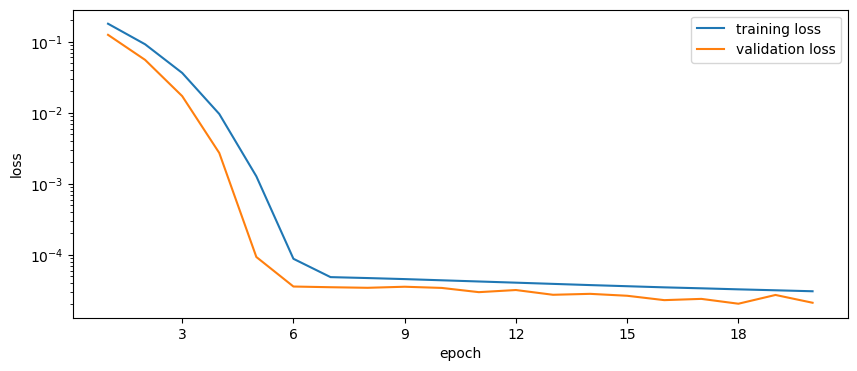

In [22]:
from matplotlib.ticker import MaxNLocator

fig, axes = plt.subplots(1, 1, figsize=(10,4))
axes.plot(np.linspace(1, len(train_losses), len(train_losses)), train_losses, label='training loss')
axes.plot(np.linspace(1, len(val_losses), len(val_losses)), val_losses, label='validation loss')
plt.legend()
plt.yscale('log')
plt.xlabel('epoch')
axes.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('loss')
plt.show()

## Define functions to make predictions and plot testdata

In [23]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    # ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    # ys = torch.ones(1, 1).to(DEVICE)
    # ys = torch.ones(1, 217).to(DEVICE) # one = BOS in language. Here use initial data value
    ys = src[0]
    # print("ys:", ys)
    
    print("ys shape", ys.shape)
    print("src shape", src.shape)
    print("src[0] shape", src[0].shape)
    
    for i in range(max_len-1):

        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        # print(ys.shape, memory.shape, tgt_mask.shape)
        
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        # print("outshape:", out.shape)
        
        # prob = model.generator(out[:, -1])
        prob = model.tgt_outlin(out[:, -1])
        
        # print("prob shape", prob.shape)
        
        # _, next_word = torch.max(prob, dim=1)
        # next_word = next_word.item()
        next_word = prob

        # print("ys:", ys.shape)
        # print("next_word", next_word.shape)
        ys = torch.cat([ys,
                        # torch.ones(1, 217).type_as(src.data).fill_(next_word)], dim=0)
                        next_word], dim=0)
        
        # print("ys after:", ys.shape)
        # print("ys full:", ys)
        
        # if next_word == EOS_IDX:
        #     break
    return ys

# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, xdata):
    model.eval()
    src = xdata.to(DEVICE)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    # print("maxlen=", num_tokens+5)
    tgt_tokens = greedy_decode(
        # model,  src, src_mask, max_len=num_tokens + 5).flatten()
        model,  src, src_mask, max_len=num_tokens)
    
    return tgt_tokens
    # return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [29]:
xdata_test = torch.Tensor(tod_train.data.compute().T).unsqueeze(1)[:MAXLEN]
cmb_pred = translate(transformer, xdata_test)

ys shape torch.Size([1, 217])
src shape torch.Size([500, 1, 217])
src[0] shape torch.Size([1, 217])


In [30]:
def plotpred(tod_test, cmb_pred, detn, skipfirst=True):
    fig, axes = plt.subplots(2, 1, figsize=(10,4))
    if skipfirst:
        axes[0].plot(tod_test.components[target].compute()[detn,:MAXLEN][10:], label=f"true atmosphere detector {detn}")
        axes[1].plot(cmb_pred.T[detn].to('cpu').detach().numpy()[10:], label=f"prediction det {detn}")
    else:
        axes[0].plot(tod_test.components[target].compute()[detn,:MAXLEN], label=f"true atmosphere detector {detn}")
        axes[1].plot(cmb_pred.T[detn].to('cpu').detach().numpy(), label=f"prediction detector {detn}")
    axes[0].legend()
    axes[1].legend()
    plt.show()

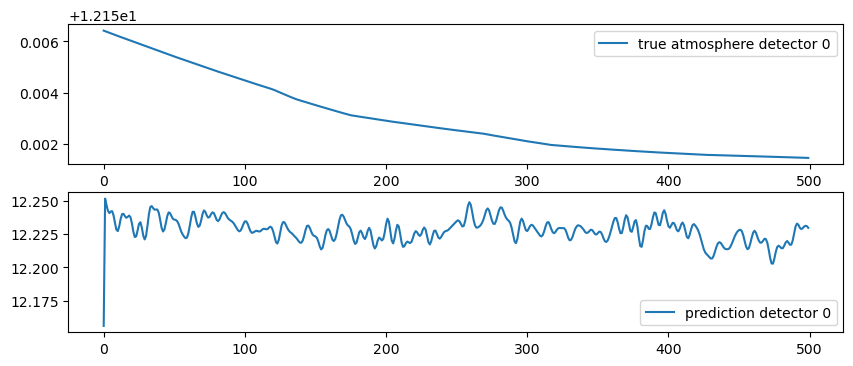

In [31]:
plotpred(tod_train, cmb_pred, 0, skipfirst=False)

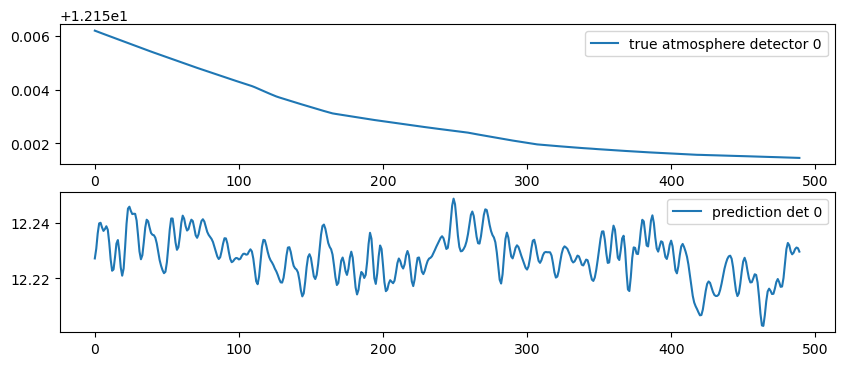

In [34]:
plotpred(tod_train, cmb_pred, 0)

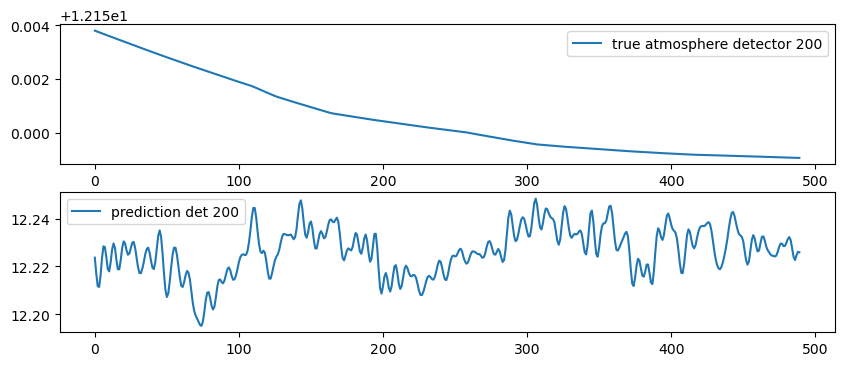

In [36]:
plotpred(tod_train, cmb_pred, 200)